In [2]:

import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
import networkx as nx
from sklearn.decomposition import PCA
import community as community_louvain  # python-louvain
import warnings
import math
import pathlib

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
DATA_DIR =r"C:\Users\rayom\OneDrive\Documentos\PROYECTO MODELOS I\multitaper-spectra-recorded-during-gabaergic-anesthetic-unconsciousness-1.0.0"
RESULTS_DIR = "results"
BANDS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30),
    'gamma': (30, 50)
}
PROPORTIONAL_THRESHOLD = 0.20  # retener top 20% de aristas si se usa umbral proporcional
N_SURROGATES = 100  # para test estadístico; aumentar si tienes tiempo computacional

In [11]:
def load_subject_csv(subject_folder):
    subject_data = {}
    csv_files = glob.glob(os.path.join(subject_folder, "*.csv"))

    for csv_file in csv_files:
        name = os.path.basename(csv_file).replace(".csv", "")

        df = pd.read_csv(csv_file, header=None)
        subject_data[name] = df.values.squeeze()

    subject_data["folder"] = subject_folder
    subject_data["id"] = os.path.basename(subject_folder)

    return subject_data

def load_dataset_csv(data_dir):
    subject_folders = glob.glob(os.path.join(data_dir, "**"), recursive=True)
    subject_folders = [f for f in subject_folders if os.path.isdir(f)]

    dataset = []

    for folder in subject_folders:
        csv_files = glob.glob(os.path.join(folder, "*.csv"))
        if len(csv_files) == 0:
            continue

        dataset.append(load_subject_csv(folder))

    print(f"Total de sujetos cargados: {len(dataset)}")
    return dataset


In [16]:
dataset = load_dataset_csv(DATA_DIR)

Total de sujetos cargados: 2


In [20]:
print([k for k in example.keys() if "_Sdb" in k])


['1014_Sdb', '1029_Sdb', '1051_Sdb', '1069_Sdb', '1071_Sdb', '132_Sdb', '133_Sdb', '143_Sdb', '154_Sdb', '208_Sdb', '212_Sdb', '222_Sdb', '223_Sdb', '228_Sdb', '244_Sdb', '281_Sdb', '300_Sdb', '373_Sdb', '455_Sdb', '511_Sdb', '54_Sdb', '62_Sdb', '630_Sdb', '65_Sdb', '695_Sdb', '697_Sdb', '703_Sdb', '713_Sdb', '724_Sdb', '731_Sdb', '788_Sdb', '790_Sdb', '796_Sdb', '806_Sdb', '808_Sdb', '811_Sdb', '834_Sdb', '839_Sdb', '856_Sdb', '858_Sdb', '867_Sdb', '908_Sdb', '937_Sdb', '962_Sdb']


In [17]:
xample = dataset[0]
print(example.keys())

dict_keys(['1014_EEGquality', '1014_f', '1014_l', '1014_Sdb', '1014_t', '1029_EEGquality', '1029_f', '1029_l', '1029_Sdb', '1029_t', '1051_EEGquality', '1051_f', '1051_l', '1051_Sdb', '1051_t', '1069_EEGquality', '1069_f', '1069_l', '1069_Sdb', '1069_t', '1071_EEGquality', '1071_f', '1071_l', '1071_Sdb', '1071_t', '132_EEGquality', '132_f', '132_l', '132_Sdb', '132_t', '133_EEGquality', '133_f', '133_l', '133_Sdb', '133_t', '143_EEGquality', '143_f', '143_l', '143_Sdb', '143_t', '154_EEGquality', '154_f', '154_l', '154_Sdb', '154_t', '208_EEGquality', '208_f', '208_l', '208_Sdb', '208_t', '212_EEGquality', '212_f', '212_l', '212_Sdb', '212_t', '222_EEGquality', '222_f', '222_l', '222_Sdb', '222_t', '223_EEGquality', '223_f', '223_l', '223_Sdb', '223_t', '228_EEGquality', '228_f', '228_l', '228_Sdb', '228_t', '244_EEGquality', '244_f', '244_l', '244_Sdb', '244_t', '281_EEGquality', '281_f', '281_l', '281_Sdb', '281_t', '300_EEGquality', '300_f', '300_l', '300_Sdb', '300_t', '373_EEGqual

In [21]:
# Encuentra la clave que termina en _Sdb
sdb_key = [k for k in example.keys() if k.endswith("_Sdb")][0]

# Extrae el ID quitando _Sdb
subject_id = sdb_key.replace("_Sdb", "")

print("ID real:", subject_id)

# Ahora sí cargas todo
Sdb = example[f"{subject_id}_Sdb"]
f    = example[f"{subject_id}_f"]
t    = example[f"{subject_id}_t"]
l    = example[f"{subject_id}_l"]

print("Sdb shape:", Sdb.shape)
print("Frecuencias:", f[:10])
print("Tiempo:", t[:10])
print("Label:", l)



ID real: 1014
Sdb shape: (100, 6570)
Frecuencias: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
Tiempo: [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
Label: [1. 1. 1. ... 0. 0. 0.]


In [22]:
# -----------------------
# Funciones para band powers, mascaras y plots
# -----------------------
def db_to_power(Sdb):
    """Convierte dB a potencia lineal. Acepta array (freq x time)."""
    return 10 ** (Sdb / 10.0)

def band_indices(freqs, band_range):
    lo, hi = band_range
    return np.where((freqs >= lo) & (freqs <= hi))[0]

def compute_band_power_per_window(Sdb, freqs, bands=BANDS):
    """
    Sdb: array shape (n_freqs, n_windows) in dB
    freqs: array of frequencies (n_freqs,)
    Devuelve: dict {band_name: 1D array length n_windows (potencia total en banda)}
    """
    pow_lin = db_to_power(Sdb)               # freq x time in linear units
    n_windows = pow_lin.shape[1]
    band_pows = {}
    for bname, rng in bands.items():
        idx = band_indices(freqs, rng)
        if idx.size == 0:
            band_pows[bname] = np.zeros(n_windows)
        else:
            # sumar potencia sobre bins de frecuencia (queda 1 x n_windows)
            band_pows[bname] = pow_lin[idx, :].sum(axis=0)
    return band_pows

def apply_masks_and_get_indices(subject, subject_id):
    """
    subject: diccionario cargado para un folder (como example)
    subject_id: string id encontrado (ej. '1014')
    Devuelve indices válidos (boolean) y índices por condición (consciente, inconsciente)
    """
    # extraer arrays
    Sdb = subject[f"{subject_id}_Sdb"]
    labels = subject.get(f"{subject_id}_l", None)
    # Si existe EEGquality (OR), aplicarlo
    eegq_key = f"{subject_id}_EEGquality"
    eegq = subject.get(eegq_key, None)
    # asumimos ventanas en axis=1
    n_windows = Sdb.shape[1]
    valid = np.ones(n_windows, dtype=bool)
    if eegq is not None:
        # esperando boolean/0-1 vector con longitud n_windows
        valid = valid & (eegq.astype(bool))
    if labels is not None:
        # No queremos NaN
        valid = valid & (~np.isnan(labels))
    # índices por condición
    conscious_idx = None
    unconscious_idx = None
    if labels is not None:
        conscious_idx = np.where((labels == 1) & valid)[0]
        unconscious_idx = np.where((labels == 0) & valid)[0]
    else:
        conscious_idx = np.array([], dtype=int)
        unconscious_idx = np.array([], dtype=int)
    return valid, conscious_idx, unconscious_idx


In [23]:
# usa el ejemplo que ya tienes cargado
subject = example            # o dataset[i] para otro sujeto
# determinar ID real (como hicimos)
sdb_key = [k for k in subject.keys() if k.endswith("_Sdb")][0]
subject_id = sdb_key.replace("_Sdb", "")

# extraer matrices
Sdb = subject[f"{subject_id}_Sdb"]   # shape freq x windows
freqs = subject[f"{subject_id}_f"]
times = subject[f"{subject_id}_t"]
labels = subject.get(f"{subject_id}_l", None)

# mascaras
valid_mask, idx_cons, idx_uncons = apply_masks_and_get_indices(subject, subject_id)
print(f"ventanas totales: {Sdb.shape[1]}, válidas: {valid_mask.sum()}, conscientes: {len(idx_cons)}, inconscientes: {len(idx_uncons)}")

# calcular band powers (toma Sdb de todas las ventanas, luego aplicamos valid_mask)
band_pows = compute_band_power_per_window(Sdb, freqs, bands=BANDS)
# aplicar máscara a cada banda (quitar ventanas inválidas)
band_pows_masked = {b: band_pows[b][valid_mask] for b in band_pows}
# para conveniencia: obtener series temporales (index corresponde a times[valid_mask])
times_valid = times[valid_mask]


ventanas totales: 6570, válidas: 6054, conscientes: 84, inconscientes: 5970


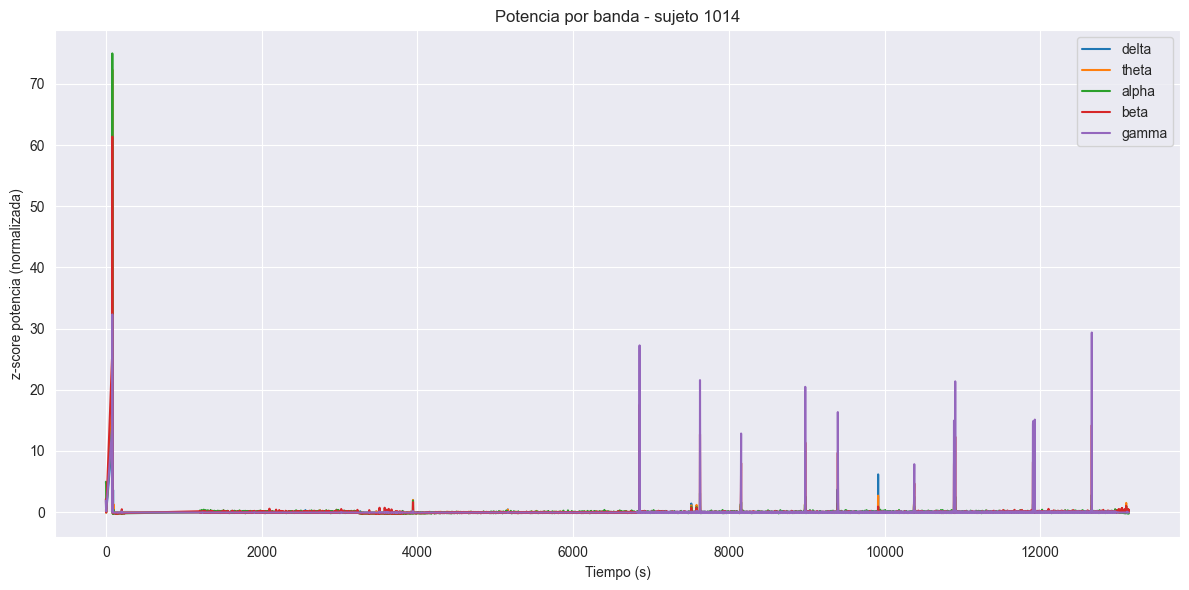

In [24]:
# Normalizar para visualización (por banda)
plt.figure(figsize=(12,6))
for bname, series in band_pows_masked.items():
    # normalizar por mediana para comparar escalas
    series_norm = series / (np.median(series) + 1e-12)
    plt.plot(times_valid, stats.zscore(series_norm), label=bname)  # z-score para comparabilidad
plt.xlabel("Tiempo (s)")
plt.ylabel("z-score potencia (normalizada)")
plt.title(f"Potencia por banda - sujeto {subject_id}")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
from scipy.stats import mannwhitneyu
results_stats = {}
if labels is not None and len(idx_cons)>0 and len(idx_uncons)>0:
    for bname, series in band_pows.items():
        # restringir a índices válidos
        series_valid = series[valid_mask]
        a = series_valid[np.where(subject[f"{subject_id}_l"][valid_mask]==1)[0]]
        b = series_valid[np.where(subject[f"{subject_id}_l"][valid_mask]==0)[0]]
        # Mann-Whitney U
        stat, p = mannwhitneyu(a, b, alternative='two-sided')
        # efecto (r) - aproximación: Z / sqrt(N)
        # get z via normal approximation from U
        n1, n2 = len(a), len(b)
        U = stat
        mu_U = n1*n2/2.0
        sigma_U = math.sqrt(n1*n2*(n1+n2+1)/12.0)
        z = (U - mu_U) / (sigma_U + 1e-12)
        r = abs(z) / math.sqrt(n1 + n2)
        results_stats[bname] = {"stat": stat, "p": p, "n1":n1, "n2":n2, "r": r}
    print("Resultados por banda (Mann-Whitney U):")
    print(pd.DataFrame(results_stats).T)
else:
    print("No hay etiquetas válidas para comparación en este sujeto.")


Resultados por banda (Mann-Whitney U):
           stat             p    n1      n2         r
delta  149989.0  2.394308e-10  84.0  5970.0  0.081402
theta   79156.0  3.985006e-27  84.0  5970.0  0.138632
alpha   68106.0  1.639935e-30  84.0  5970.0  0.147559
beta    73988.0  1.103809e-28  84.0  5970.0  0.142807
gamma  277932.0  8.737964e-02  84.0  5970.0  0.021970


In [26]:
out_dir = os.path.join(RESULTS_DIR, subject_id)
os.makedirs(out_dir, exist_ok=True)
# guardar band powers (ventanas válidas)
np.savez_compressed(os.path.join(out_dir, f"{subject_id}_bandpowers.npz"), times=times_valid, **band_pows_masked)
# guardar estadística
with open(os.path.join(out_dir, f"{subject_id}_band_stats.json"), 'w') as f:
    json.dump(results_stats, f, indent=2)
print("Guardado en:", out_dir)


Guardado en: results\1014


In [27]:
# Vector de características por ventana (ventanas válidas)
# shape final: (n_ventanas_validas, n_bandas)
feature_matrix = np.vstack([band_pows_masked[b] for b in BANDS.keys()]).T

print("feature_matrix shape:", feature_matrix.shape)


feature_matrix shape: (6054, 5)


In [28]:
# matriz de similitud entre ventanas
sim_matrix = np.corrcoef(feature_matrix.T)  # <- OJO: esto correlaciona bandas, NO ventanas
sim_matrix = np.corrcoef(feature_matrix)  # correlación ventana-ventana
print(sim_matrix.shape)


(6054, 6054)


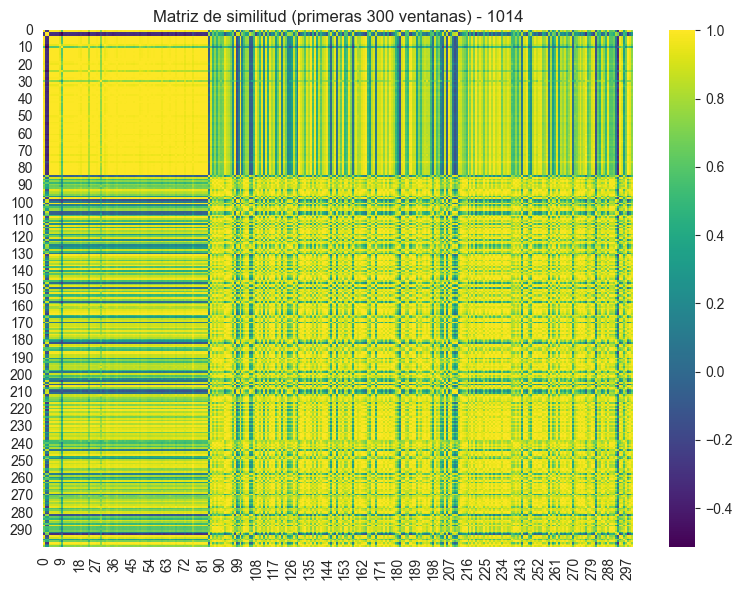

In [29]:
subset = 300
plt.figure(figsize=(8,6))
sns.heatmap(sim_matrix[:subset, :subset], cmap="viridis")
plt.title(f"Matriz de similitud (primeras {subset} ventanas) - {subject_id}")
plt.tight_layout()
plt.show()


In [34]:
thr = PROPORTIONAL_THRESHOLD  # 0.20 → top 20%

# Convertir matriz a vector (excluyendo diagonal)
sim_flat = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
cut = np.quantile(sim_flat, 1-thr)

# Crear matriz binarizada
A = (sim_matrix >= cut).astype(int)
np.fill_diagonal(A, 0)

print("Threshold aplicado:", cut)
print("Aristas retenidas:", A.sum())

# Recalcular threshold si no existe
PROPORTIONAL_THRESHOLD = 0.20  # 20%

# Obtener el valor numérico del threshold
flat_sim = sim_matrix.flatten()
flat_sim = flat_sim[~np.isnan(flat_sim)]
threshold = np.percentile(flat_sim, 100 * (1 - PROPORTIONAL_THRESHOLD))

print("Threshold:", threshold)


Threshold aplicado: 0.9822596264063946
Aristas retenidas: 7328974
Threshold: 0.9822747997148578


In [35]:
# 6.5 Construir la matriz de adyacencia binaria
adj_matrix = (sim_matrix >= threshold).astype(int)

# Quitar autosimilaridad (diagonal = 0)
np.fill_diagonal(adj_matrix, 0)

print("Adjacency matrix shape:", adj_matrix.shape)
print("Aristas totales:", adj_matrix.sum())


Adjacency matrix shape: (6054, 6054)
Aristas totales: 7324130


In [36]:
# Construir el Grafo

G = nx.from_numpy_array(adj_matrix)

print("Nodos en G:", G.number_of_nodes())
print("Aristas en G:", G.number_of_edges())


Nodos en G: 6054
Aristas en G: 3662065


In [42]:
# obtener el id real (ya te salió: 1014)
sdb_key = [k for k in example.keys() if k.endswith("_Sdb")][0]
subject_id = sdb_key.replace("_Sdb", "")
print("Subject ID real:", subject_id)

# cargar variables
Sdb = example[f"{subject_id}_Sdb"]
quality = example[f"{subject_id}_EEGquality"]

# filtrar ventanas buenas
valid_mask = (quality == 1)
n_valid = valid_mask.sum()

print("n_valid:", n_valid)


Subject ID real: 1014
n_valid: 6534


In [44]:
labels_bool = example[f"{subject_id}_l"][:n_valid]

In [47]:
# Ver cuántos nodos tienes realmente
n_graph = G.number_of_nodes()
print("N nodos en G:", n_graph)

# Recortar etiquetas al número de nodos válidos
labels_bool = labels_bool[:n_graph]

# Asignar estado nodo por nodo
for i in range(n_graph):
    G.nodes[i]["state"] = "conscious" if labels_bool[i] == 1 else "unconscious"


N nodos en G: 6054


In [49]:
# Contar cuántos nodos quedaron en cada estado

from collections import Counter

states = [G.nodes[i]["state"] for i in G.nodes()]
Counter(states)


Counter({'unconscious': 5934, 'conscious': 120})

In [ ]:
print("Nodos:", G.number_of_nodes())
print("Aristas:", G.number_of_edges())

# Mostrar 5 nodos aleatorios con su estado
import random
sample_nodes = random.sample(list(G.nodes()), 5)
print("\nMuestra de nodos con atributos:")
for n in sample_nodes:
    print(n, G.nodes[n])
